In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard

In [2]:
import get_base_model as generate_models

In [3]:
def lr_scheduler(epoch, learning_rate):
    initial_learning_rate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    learning_rate = initial_learning_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return learning_rate

In [4]:
def train_model(compound_model, train, y_train, validation, y_validation, epochs, batch_size, optimizer='sgd'):

    # Early Stopping

    if epochs > 50:
        patience = .20*epochs
    else:
        patience = 0.30*epochs

    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, baseline = 0.87, patience = patience)

    # learning schedule callback
    learning_rate = LearningRateScheduler(lr_scheduler)

    # Checkpointing
    filepath="weights-modification-training-mod-" + optimizer.lower() + "-batchsize-" + str(batch_size) + "-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Tensorboard
    tensorboard_callback = TensorBoard(log_dir="./logs")

    # Optimizer
    
    if optimizer.lower() == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.1)
        callback_list = [early_stop, checkpoint, tensorboard_callback]
        
    elif optimizer.lower() == 'sgd':
        momentum = 0.8
        opt = tf.keras.optimizers.SGD(lr=0.0, momentum=momentum)
        callback_list = [early_stop, learning_rate, checkpoint, tensorboard_callback]

    # Compile model
    compound_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Train model
    compound_model.fit(train, y_train, validation_data=(validation, y_validation), epochs=epochs, batch_size=batch_size, callbacks=callback_list)
    
    return compound_model

In [6]:
# Define Models and load pre-trained weights

base_model = generate_models.gen_base_model()
base_model.load_weights('pre-trained.hdf5')

top_layers = generate_models.new_top_model()
top_layers.build(input_shape=[None,4096])

# Define a combined model

compound_model = tf.keras.Sequential([
  base_model,
  top_layers
])

compound_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4096)              117479232 
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1116929   
Total params: 118,596,161
Trainable params: 1,115,905
Non-trainable params: 117,480,256
_________________________________________________________________


In [7]:
# Load data

# Training
train = np.load('final_train.npy')
y_train = np.load('final_train_y.npy')

# Validation
validation = np.load('final_val.npy')
y_validation = np.load('final_val_y.npy')

# Test
test = np.load('final_test.npy')
y_test = np.load('final_test_y.npy')




In [10]:
# Compile and train model

compound_model = train_model(compound_model, train, y_train, validation, y_validation, epochs = 10, batch_size = 40, optimizer='adam')


Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.8667 - accuracy: 0.4500WARNING:tensorflow:From C:\Users\anark\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.6442WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0085s vs `on_test_batch_end` time: 0.1486s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to weights-modification-training-mod-adam-batchsize-40-01-0.50.hdf5
100/100 [==============================] - 21s 210ms/step - loss: 0.9918 - accuracy: 0.6442 - val_loss: 17.6463 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7225
Epoch 

Female


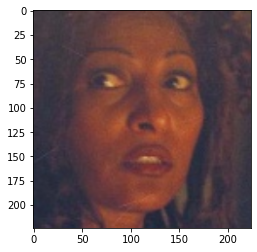

In [12]:
# Sample Inference

sample = np.ndarray([1,224,224,3])
sample[0,:,:,:] = test[8]
np.shape(sample)

plt.imshow(sample[0])

if (compound_model.predict(sample)[0] > 0.5):
    print('Female')
else: 
    print('Male')